#### Description

The purpose of this notebook is to get to know the data and finally to prototype torch datasets for them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# needed for dataset
import json
import os
from collections import namedtuple
from typing import Any, Callable, Dict, List, Optional, Union, Tuple

from torchvision.datasets.utils import extract_archive, verify_str_arg, iterable_to_str
from torchvision.datasets.vision import VisionDataset
from PIL import Image

# kitti

The Kitti dataset was obtained from the [dataset website](http://www.cvlibs.net/datasets/kitti/eval_scene_flow.php).

From the kitti readme:

File naming examples:
=====================

Test stereo pair '000005':

 - left image:  testing/image_2/000005_10.png
 - right image: testing/image_3/000005_10.png

Test flow pair '000005':

 - first frame:  testing/image_2/000005_10.png
 - second frame: testing/image_2/000005_11.png
 
Scene flow test scene '000005':

 - left image of the first pair:   testing/image_2/000005_10.png
 - right image of the first pair:  testing/image_3/000005_10.png
 - left image of the second pair:  testing/image_2/000005_11.png
 - right image of the second pair: testing/image_3/000005_11.png 
 
 furthermore:
 
 - disp_xxx_0: Disparity maps of first image pairs in reference frame
              (only regions which don't leave the image domain).

- disp_xxx_1: Disparity information of second image pair mapped into the
              reference frame (first left image) via the true optical flow.

- flow_xxx:   Optical flow which maps from the first left to the second left
              image. Specified in the reference frame (first left image).
              
Note that image_2 refers to a left image, image_3 refers to a right image.

Also:

'noc' refers to non-occluded regions, ie, regions for which the matching
correspondence is inside the image domain. 'occ' refers to all image
regions for which ground truth could be measured (including regions which map
to points outside the image domain in the other view). In the KITTI online
evaluation both types of image regions are evaluated (see detailed results of
the respective method), however for ranking the methods and for the main table
all image regions are considered (corresponding to the 'occ' folders).

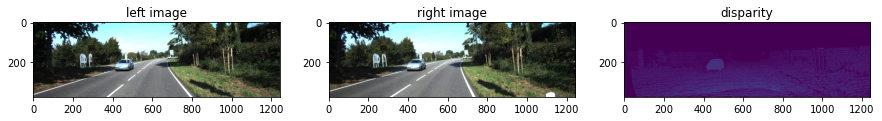

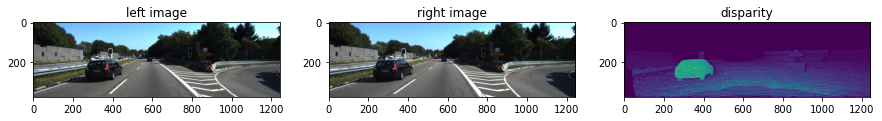

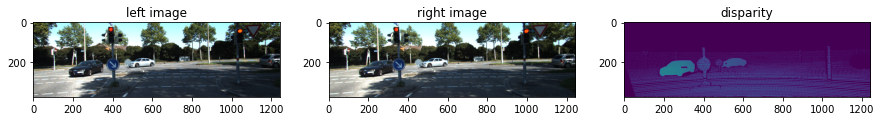

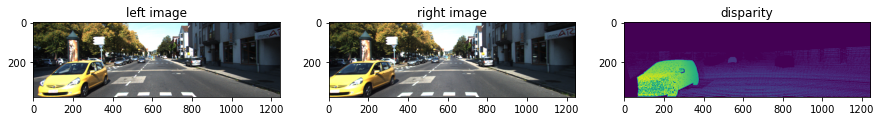

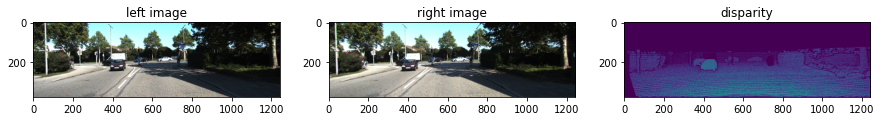

Number of left images: 200


In [2]:
kitti_root = '/home/data/kitti'
image_2_path = os.path.join(kitti_root, 'training/image_2')

left_imgs_paths = []
for img in os.listdir(image_2_path):
    if '10.png' in img:
        left_imgs_paths.append(os.path.join(image_2_path, img))
        
def left_to_right(left_img_path):
    split_path = left_img_path.split('/')
    root, _, img = split_path[:-2], split_path[-2], split_path[-1]
    return os.path.join('/', *root, 'image_3', img)

# Modes: 'disp_noc_0', 'disp_occ_0', 'disp_noc_1', 'disp_occ_1'
def left_to_disparity(left_img_path, mode='disp_noc_0'):
    split_path = left_img_path.split('/')
    root, img = split_path[:-1], split_path[-1]
    root[-1] = mode
    return os.path.join('/', *root, img)

right_imgs_paths = [left_to_right(path) for path in left_imgs_paths]
disparity_paths = [left_to_disparity(path) for path in left_imgs_paths]

for i in np.random.choice(np.arange(len(left_imgs_paths)), size=5, replace=False):
    img_path_left = left_imgs_paths[i]
    img_left = np.asarray(Image.open(img_path_left))
    
    img_path_right = right_imgs_paths[i]
    img_right = np.asarray(Image.open(img_path_right))
    
    img_path_disparity = disparity_paths[i]
    img_disparity = np.asarray(Image.open(img_path_disparity))
    
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img_left)
    axes[0].set_title('left image')
    
    axes[1].imshow(img_right)
    axes[1].set_title('right image')
    
    axes[2].imshow(img_disparity)
    axes[2].set_title('disparity')
    
    plt.show()

n_kitti = len(left_imgs_paths)
print(f'Number of left images: {n_kitti}')

# sceneflow

All SceneFlow datasets were obtained from the [dataset website](https://lmb.informatik.uni-freiburg.de/resources/datasets/SceneFlowDatasets.en.html).

## monkaa

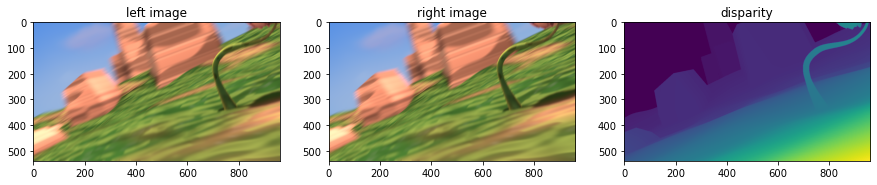

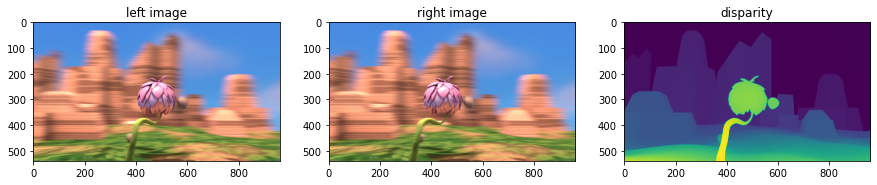

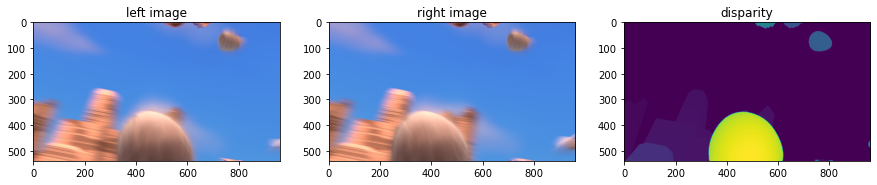

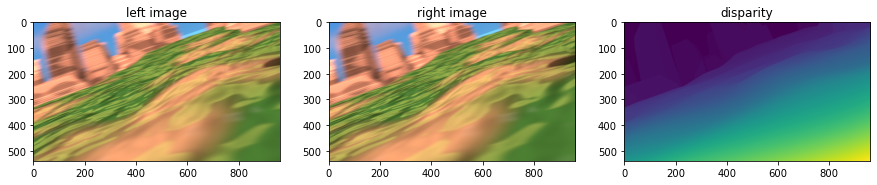

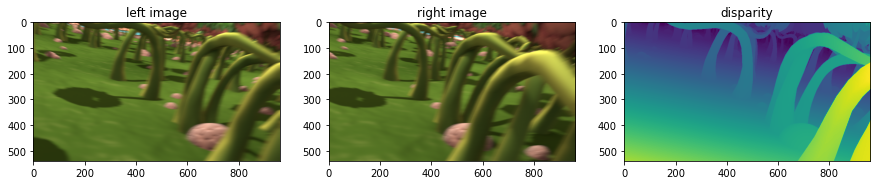

Number of left images: 8664


In [3]:
#125 images in each folder? -> no!
#is each image 540 x 960? yes
from pypfm import PFMLoader
#loader = PFMLoader((540, 960), color=False, compress=False)
loader = PFMLoader(color=False, compress=False)

sceneflow_root = '/home/data/sceneflow'
subset = 'monkaa'
    
left_imgs_paths = []
for key in os.listdir(os.path.join(sceneflow_root,subset, 'frames_finalpass')):
            for img in os.listdir(os.path.join(sceneflow_root, subset, 'frames_finalpass', key, 'left')):
                left_imgs_paths.append(os.path.join(sceneflow_root, subset, 'frames_finalpass', key, 'left', img))

def left_to_right(left_img_path):
    split_path = left_img_path.split('/')
    root, _, img = split_path[:-2], split_path[-2], split_path[-1]
    return os.path.join('/', *root, 'right', img)

def left_to_disparity(left_img_path):
    split_path = left_img_path.split('/')
    root, side, img = split_path[:-2], split_path[-2], split_path[-1]
    root[-2] = 'disparity'
    img = img.split('.')[0]
    return os.path.join('/', *root, side, img + '.pfm')

right_imgs_paths = [left_to_right(path) for path in left_imgs_paths]
disparity_paths = [left_to_disparity(path) for path in left_imgs_paths]

for i in np.random.choice(np.arange(len(left_imgs_paths)), size=5, replace=False):
    img_path_left = left_imgs_paths[i]
    img_left = np.asarray(Image.open(img_path_left))
    
    img_path_right = right_imgs_paths[i]
    img_right = np.asarray(Image.open(img_path_right))
    
    img_path_disparity = disparity_paths[i]
    img_disparity = np.flipud(loader.load_pfm(img_path_disparity))
    
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img_left)
    axes[0].set_title('left image')
    
    axes[1].imshow(img_right)
    axes[1].set_title('right image')
    
    axes[2].imshow(img_disparity)
    axes[2].set_title('disparity')
    
    plt.show()

n_monkaa = len(left_imgs_paths)
print(f'Number of left images: {n_monkaa}')

## driving

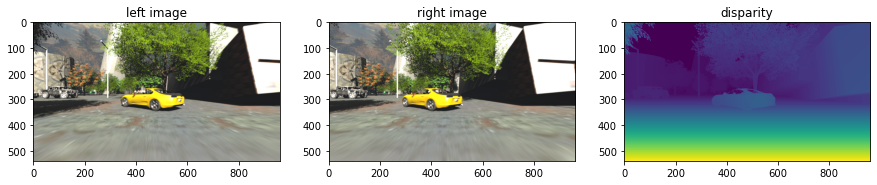

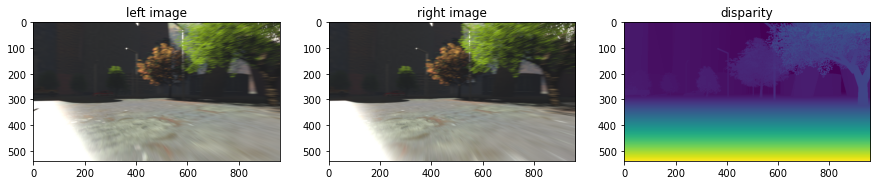

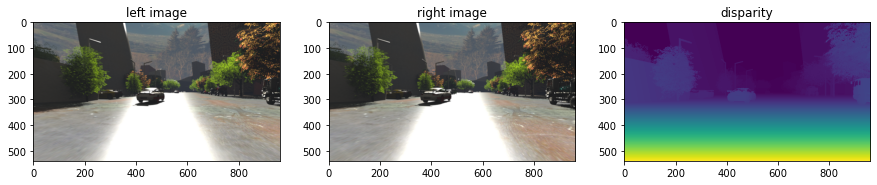

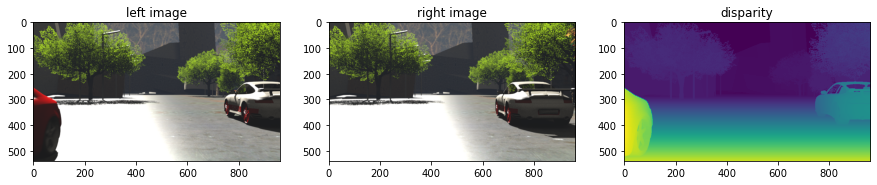

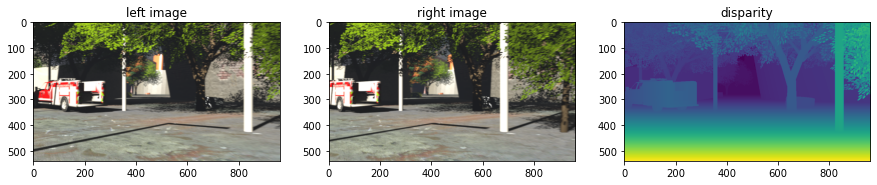

Number of left images: 4400


In [4]:
#loader = PFMLoader((540, 960), color=False, compress=False)
loader = PFMLoader(color=False, compress=False)

sceneflow_root = '/home/data/sceneflow'
subset = 'driving'

left_imgs_paths = []
for key in os.listdir(os.path.join(sceneflow_root,subset, 'frames_finalpass')):
    for subkey in os.listdir(os.path.join(sceneflow_root, subset, 'frames_finalpass', key)):
        for subsubkey in os.listdir(os.path.join(sceneflow_root, subset, 'frames_finalpass', key, subkey)):
            for img in os.listdir(os.path.join(sceneflow_root, subset, 'frames_finalpass', key, subkey, subsubkey, 'left')):
                left_imgs_paths.append(os.path.join(sceneflow_root, subset, 'frames_finalpass', key, subkey, subsubkey, 'left', img))
    

def left_to_right(left_img_path):
    split_path = left_img_path.split('/')
    root, _, img = split_path[:-2], split_path[-2], split_path[-1]
    return os.path.join('/', *root, 'right', img)

def left_to_disparity(left_img_path):
    split_path = left_img_path.split('/')
    root, side, img = split_path[:-2], split_path[-2], split_path[-1]
    root[-4] = 'disparity'
    img = img.split('.')[0]
    return os.path.join('/', *root, side, img + '.pfm')

right_imgs_paths = [left_to_right(path) for path in left_imgs_paths]
disparity_paths = [left_to_disparity(path) for path in left_imgs_paths]

for i in np.random.choice(np.arange(len(left_imgs_paths)), size=5, replace=False):
    img_path_left = left_imgs_paths[i]
    img_left = np.asarray(Image.open(img_path_left))
    
    img_path_right = right_imgs_paths[i]
    img_right = np.asarray(Image.open(img_path_right))
    
    img_path_disparity = disparity_paths[i]
    img_disparity = np.flipud(loader.load_pfm(img_path_disparity))
    
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img_left)
    axes[0].set_title('left image')
    
    axes[1].imshow(img_right)
    axes[1].set_title('right image')
    
    axes[2].imshow(img_disparity)
    axes[2].set_title('disparity')
    
    plt.show()

n_driving = len(left_imgs_paths)
print(f'Number of left images: {n_driving}')

## flyingthings3d

##### Note: The exceedingly difficult examples in this dataset can removed as per the instructions on the dataset website

The corresponding file names are in *all_unused_files.txt* at the flyingthings3d root. This reduces the number of samples from 26760 to 26066.

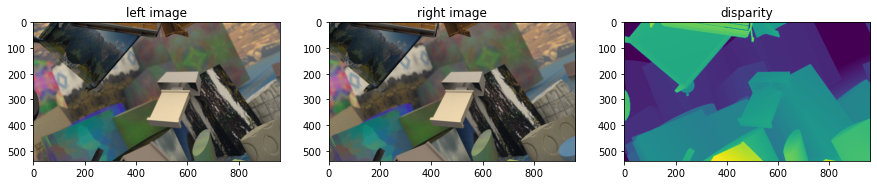

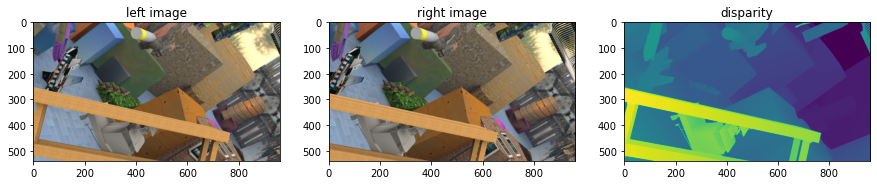

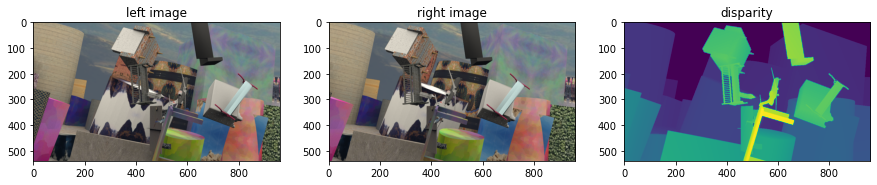

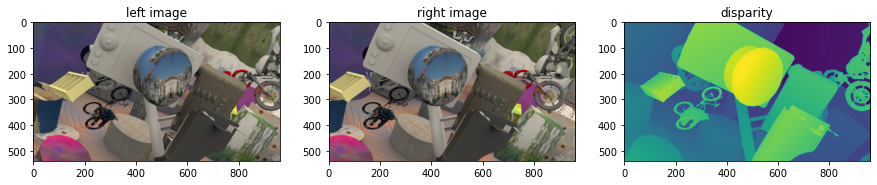

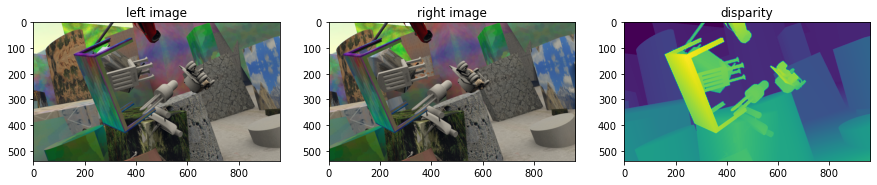

Number of left images: 26066


In [5]:
#loader = PFMLoader((540, 960), color=False, compress=False)
loader = PFMLoader(color=False, compress=False)

sceneflow_root = '/home/data/sceneflow'
subset = 'flyingthings3d'

# Toggle this flag to determine whether difficult examples are used
use_difficult_examples = False
difficult_examples = np.genfromtxt(os.path.join(sceneflow_root, subset, 'all_unused_files.txt'), dtype=str)

left_imgs_paths = []
for key in os.listdir(os.path.join(sceneflow_root,subset, 'frames_finalpass')):
    for subkey in os.listdir(os.path.join(sceneflow_root, subset, 'frames_finalpass', key)):
        for subsubkey in os.listdir(os.path.join(sceneflow_root, subset, 'frames_finalpass', key, subkey)):
            for img in os.listdir(os.path.join(sceneflow_root, subset, 'frames_finalpass', key, subkey, subsubkey, 'left')):
                if not os.path.join(key,subkey,subsubkey,'left', img) in difficult_examples or use_difficult_examples:
                    left_imgs_paths.append(os.path.join(sceneflow_root, subset, 'frames_finalpass', key, subkey, subsubkey, 'left', img))

def left_to_right(left_img_path):
    split_path = left_img_path.split('/')
    root, _, img = split_path[:-2], split_path[-2], split_path[-1]
    return os.path.join('/', *root, 'right', img)

def left_to_disparity(left_img_path):
    split_path = left_img_path.split('/')
    root, side, img = split_path[:-2], split_path[-2], split_path[-1]
    root[-4] = 'disparity'
    img = img.split('.')[0]
    return os.path.join('/', *root, side, img + '.pfm')


right_imgs_paths = [left_to_right(path) for path in left_imgs_paths]
disparity_paths = [left_to_disparity(path) for path in left_imgs_paths]

for i in np.random.choice(np.arange(len(left_imgs_paths)), size=5, replace=False):
    img_path_left = left_imgs_paths[i]
    img_left = np.asarray(Image.open(img_path_left))
    
    img_path_right = right_imgs_paths[i]
    img_right = np.asarray(Image.open(img_path_right))
    
    img_path_disparity = disparity_paths[i]
    img_disparity = np.flipud(loader.load_pfm(img_path_disparity))
    
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img_left)
    axes[0].set_title('left image')
    
    axes[1].imshow(img_right)
    axes[1].set_title('right image')
    
    axes[2].imshow(img_disparity)
    axes[2].set_title('disparity')
    
    plt.show()

n_flyingthings3d = len(left_imgs_paths)
print(f'Number of left images: {n_flyingthings3d}')

In [6]:
print(f'The total number of left frames in sceneflow is {n_monkaa + n_driving + n_flyingthings3d}')

The total number of left frames in sceneflow is 39130


# Cityscapes

Cityscapes was obtained from the [dataset website](https://www.cityscapes-dataset.com/) (requires registration) via the download functionality of the [cityscapes scripts](https://github.com/mcordts/cityscapesScripts).

Number of left images: 5000


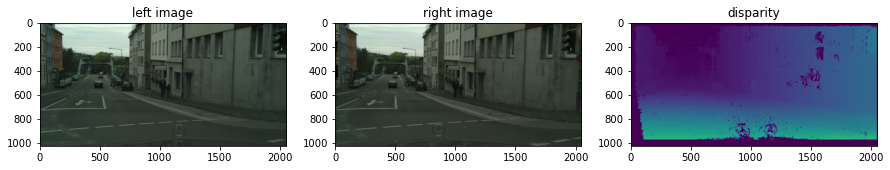

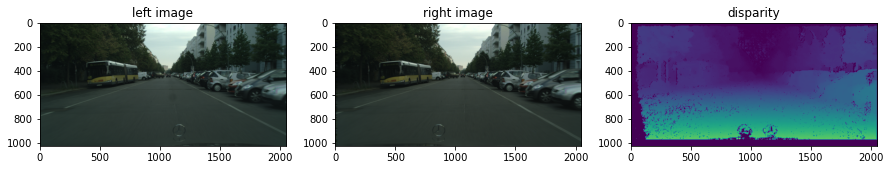

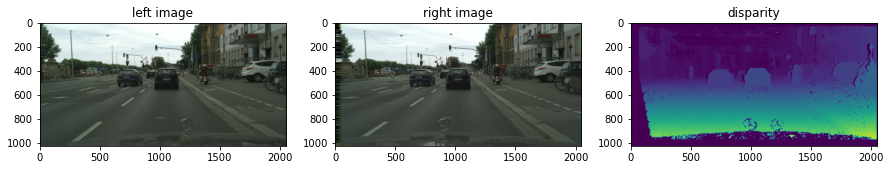

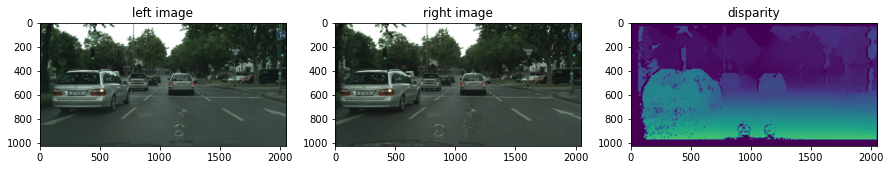

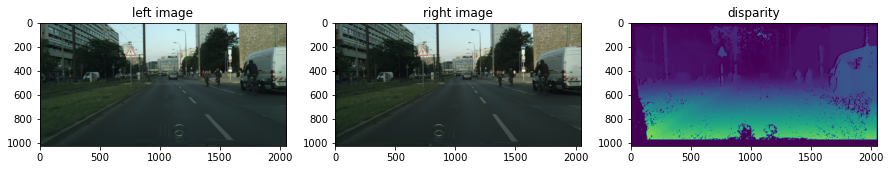

In [7]:
from skimage import io

cityscapes_root = '/home/data/cityscapes'
left_images_path = os.path.join(cityscapes_root, 'leftImg8bit')
left_imgs_paths = []
for split in os.listdir(left_images_path):
    for city in os.listdir(os.path.join(left_images_path, split)):
        for img in os.listdir(os.path.join(left_images_path, split, city)):
            left_imgs_paths.append(os.path.join(left_images_path, split, city,img))
n_cityscapes = len(left_imgs_paths)
print(f'Number of left images: {n_cityscapes}')

def left_to_right(left_img_path):
    split_path = left_img_path.split('/')
    topic, split, city, img_left = split_path[-4:]
    root = os.path.join(*split_path[:-4])
    _, seq, frame, left = img_left.split('_')
    img_right = city + '_' + seq + '_' + frame + '_rightImg8bit.png'
    return os.path.join('/', root, 'rightImg8bit_sequence', split, city, img_right)

def left_to_disparity(left_img_path):
    split_path = left_img_path.split('/')
    topic, split, city, img_left = split_path[-4:]
    root = os.path.join(*split_path[:-4])
    _, seq, frame, left = img_left.split('_')
    img_right = city + '_' + seq + '_' + frame + '_disparity.png'
    return os.path.join('/', root, 'disparity_sequence', split, city, img_right)

right_imgs_paths = [left_to_right(path) for path in left_imgs_paths]
disparity_paths = [left_to_disparity(path) for path in left_imgs_paths]

for i in np.random.choice(np.arange(len(left_imgs_paths)), size=5, replace=False):
    img_path_left = left_imgs_paths[i]
    img_left = np.asarray(Image.open(img_path_left))
    
    img_path_right = right_imgs_paths[i]
    img_right = np.asarray(Image.open(img_path_right))
    
    img_path_disparity = disparity_paths[i]
    img_disparity = io.imread(img_path_disparity).astype(np.float32)
    mask = img_disparity == 0
    img_disparity = (img_disparity - 1) / 256.
    img_disparity[mask] = 0
    
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img_left)
    axes[0].set_title('left image')
    
    axes[1].imshow(img_right)
    axes[1].set_title('right image')
    
    axes[2].imshow(img_disparity)
    axes[2].set_title('disparity')
    
    plt.show()

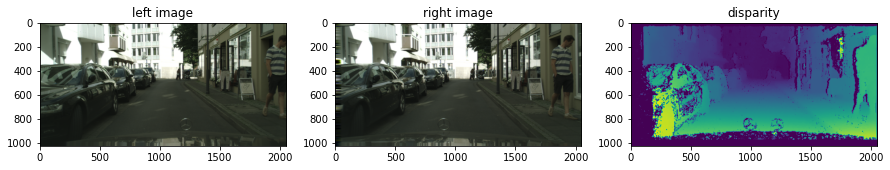

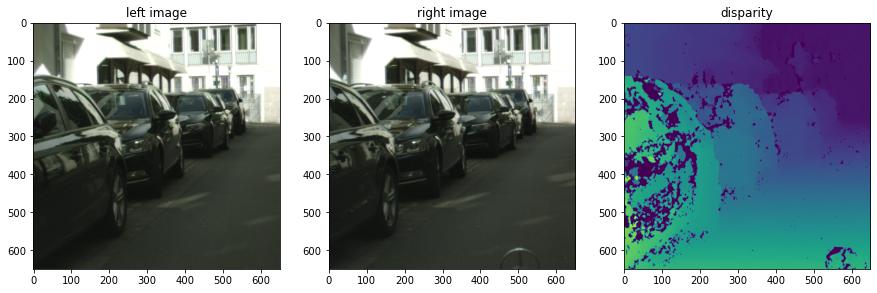

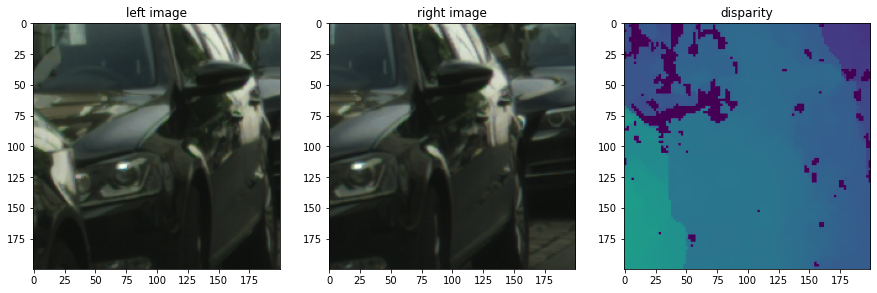

In [8]:
i = 500
x, y = 400, 200
w, h = 650, 650
img_path_left = left_imgs_paths[i]
img_left = np.asarray(Image.open(img_path_left))

img_path_right = right_imgs_paths[i]
img_right = np.asarray(Image.open(img_path_right))

img_path_disparity = disparity_paths[i]
img_disparity = io.imread(img_path_disparity).astype(np.float32)
mask = img_disparity == 0
img_disparity = (img_disparity - 1) / 256.
vmin, vmax = img_disparity.min(), img_disparity.max()
img_disparity[mask] = 0
img_disparity = img_disparity

_, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_left)
axes[0].set_title('left image')

axes[1].imshow(img_right)
axes[1].set_title('right image')

axes[2].imshow(img_disparity, vmin=vmin, vmax=vmax)
axes[2].set_title('disparity')

plt.show()

_, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_left[y:y+h, x:x+w, :])
axes[0].set_title('left image')

axes[1].imshow(img_right[y:y+h, x:x+w, :])
axes[1].set_title('right image')

axes[2].imshow(img_disparity[y:y+h, x:x+w], vmin=vmin, vmax=vmax)
axes[2].set_title('disparity')

plt.show()

x, y = 600, 400
w, h = 200, 200

_, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_left[y:y+h, x:x+w, :])
axes[0].set_title('left image')

axes[1].imshow(img_right[y:y+h, x:x+w, :])
axes[1].set_title('right image')

axes[2].imshow(img_disparity[y:y+h, x:x+w], vmin=vmin, vmax=vmax)
axes[2].set_title('disparity')

plt.show()